In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'forest-cover-type-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F308%2F668%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240923%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240923T174551Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da8a599e08f8b1f92ccbd3993a79a974d8a6a6f49d9b4ef5246e2dae199c5d6767fe550772dd14bfcf6417ac2e9e2f5e38f4a6df5d1b2e328f44e73891938df41c69465019cd312c51aa5be780e9f1b7865a3b253086176118e24cbd65351deb36826d9137b92c36360ca49210c00480f6a18f352ed477c462ae5fd9f9644dc368905b04550bb02a5f5385205ea552bf586f2127e7fe802874a05ec03193b8ef3fbf7279f21e9db564b61d4b925d0a0e99c06b6973759a25774404017f44467db26dcbfbe9ea49326e79b019f3c66bb377fecc888162b0997758fd80efa014ac0d529d23a8df7b3715e3b9b7d4dfc3db7dbd54cf227c9829bc71764a55415fd84'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/forest-cover-type-dataset/covtype.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.data import Dataset
import keras
from keras.utils import to_categorical
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from keras import models
from keras import layers

Using TensorFlow backend.


In [ ]:
df=pd.read_csv('/kaggle/input/forest-cover-type-dataset/covtype.csv',index_col=0)

In [ ]:
df.head()

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Elevation,,,,,,,,,,,,,,,,,,,,,
2596,51,3,258,0,510,221,232,148,6279,1,...,0,0,0,0,0,0,0,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,1,...,0,0,0,0,0,0,0,0,0,5
2804,139,9,268,65,3180,234,238,135,6121,1,...,0,0,0,0,0,0,0,0,0,2
2785,155,18,242,118,3090,238,238,122,6211,1,...,0,0,0,0,0,0,0,0,0,2
2595,45,2,153,-1,391,220,234,150,6172,1,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
df.info()
# We can see all columns have diffrent data types , float64(47), int64(7).

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581012 entries, 2596 to 2383
Data columns (total 54 columns):
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Wilderness_Area1                      581012 non-null int64
Wilderness_Area2                      581012 non-null int64
Wilderness_Area3                      581012 non-null int64
Wilderness_Area4                      581012 non-null int64
Soil_Type1                            581012 non-null int64
Soil_Type2                            581012 non

* No Misssing values are presents

In [ ]:
df.describe()

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


**SHAPE**

In [ ]:
print(df.shape)

# We can see that there are 154340 instances having 55 attributes

(581012, 54)


In [ ]:
# Statistical description

pd.set_option('display.max_columns', None)
print(df.describe())

# Learning :
# No attribute is missing as count is 581012 for all attributes. Hence, all rows can be used
# Negative value(s) present in Vertical_Distance_To_Hydrology. Hence, some tests such as chi-sq cant be used.
# Wilderness_Area and Soil_Type are one hot encoded. Hence, they could be converted back for some analysis
# Scales are not the same for all. Hence, rescaling and standardization may be necessary for some algos

              Aspect          Slope  Horizontal_Distance_To_Hydrology  \
count  581012.000000  581012.000000                     581012.000000   
mean      155.656807      14.103704                        269.428217   
std       111.913721       7.488242                        212.549356   
min         0.000000       0.000000                          0.000000   
25%        58.000000       9.000000                        108.000000   
50%       127.000000      13.000000                        218.000000   
75%       260.000000      18.000000                        384.000000   
max       360.000000      66.000000                       1397.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                   581012.000000                    581012.000000   
mean                        46.418855                      2350.146611   
std                         58.295232                      1559.254870   
min                       -173.000000         

SKEWNESS

In [ ]:
# Skewness of the distribution

print(df.skew())

# Values close to 0 show less skew
# Several attributes in Soil_Type show a large skew. Hence, some algos may benefit if skew is corrected

Aspect                                  0.402628
Slope                                   0.789273
Horizontal_Distance_To_Hydrology        1.140437
Vertical_Distance_To_Hydrology          1.790250
Horizontal_Distance_To_Roadways         0.713679
Hillshade_9am                          -1.181147
Hillshade_Noon                         -1.063056
Hillshade_3pm                          -0.277053
Horizontal_Distance_To_Fire_Points      1.288644
Wilderness_Area1                        0.205618
Wilderness_Area2                        4.061595
Wilderness_Area3                        0.257822
Wilderness_Area4                        3.575561
Soil_Type1                             13.736670
Soil_Type2                              8.615358
Soil_Type3                             10.838630
Soil_Type4                              6.625176
Soil_Type5                             18.995243
Soil_Type6                              9.240061
Soil_Type7                             74.367173
Soil_Type8          

**CLASS DISTRIBUTION**

In [ ]:
# Number of instances belonging to each class

df.groupby('Cover_Type').size()


# We see that all classes not have an equal presence. So, class re-balancing is necessary

Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
dtype: int64

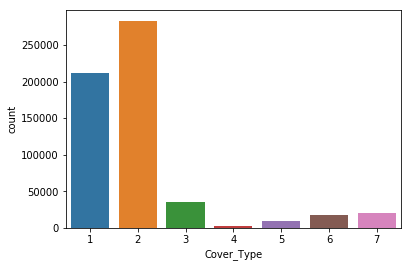

In [ ]:
a=df['Cover_Type']
sns.countplot(a)

In [ ]:
g = df.groupby('Cover_Type')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
g.head(8)

Aspect  Slope  Horizontal_Distance_To_Hydrology  \
Cover_Type                                                      
1          0     177     15                               306   
           1      44     21                               417   
           2     317     12                               124   
           3       9      8                               474   
           4      23     15                               552   
           5     123     11                               510   
           6     277     19                                90   
           7     129     25                                67   

              Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
Cover_Type                                                                      
1          0                              33                             2940   
           1                              89                             4980   
           2                              19                             2586   
           3                             -17                             1448   
           4                             183                             3519   
           5                              17                              997   
           6                              35                             3874   
           7                              10                             1047   

              Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
Cover_Type                                                   
1          0            226             247            150   
           1            220             189             95   
           2            187             229            182   
           3            211             224            150   
           4            210             207            130   
           5            239             231            121   
           6            167             240            212   
           7            251             217             79   

              Horizontal_Distance_To_Fire_Points  Wilderness_Area1  \
Cover_Type                                                           
1          0                                1839                 0   
           1                                3245                 1   
           2                                2918                 1   
           3                                1947                 1   
           4                                1848                 0   
           5                                2711                 1   
           6                                1020                 1   
           7                                 552                 0   

              Wilderness_Area2  Wilderness_Area3  Wilderness_Area4  \
Cover_Type                                                           
1          0                 0                 1                 0   
           1                 0                 0                 0   
           2                 0                 0                 0   
           3                 0                 0                 0   
           4                 0                 1                 0   
           5                 0                 0                 0   
           6                 0                 0                 0   
           7                 0                 1                 0   

              Soil_Type1  Soil_Type2  Soil_Type3  Soil_Type4  Soil_Type5  \
Cover_Type                                                                 
1          0           0           0           0           0           0   
           1           0           0           0           0           0   
           2           0           0           0           0           0   
           3           0           0           0           0           0   
           4           0           0           0           0           0 

**Explorartory Data Analysis**

DATA INTERGRATION

1. Correlation

* Correlation tells relation between two attributes.
* Correlation requires continous data. Hence, ignore Wilderness_Area and Soil_Type as they are binary

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy



#sets the number of features considered
size = 10

#create a dataframe with only 'size' features
data=df.iloc[:,:size]

#get the names of all the columns
cols=data.columns

# Calculates pearson co-efficient for all combinations
data_corr = data.corr()

# Set the threshold to select only only highly correlated attributes
threshold = 0.5

# List of pairs along with correlation above threshold
corr_list = []

#Search for the highly correlated pairs
for i in range(0,size): #for 'size' features
    for j in range(i+1,size): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

# Strong correlation is observed between the following pairs
# This represents an opportunity to reduce the feature set through transformations such as PCA

Hillshade_9am and Hillshade_3pm = -0.78
Aspect and Hillshade_3pm = 0.65
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology = 0.61
Hillshade_Noon and Hillshade_3pm = 0.59
Aspect and Hillshade_9am = -0.58
Slope and Hillshade_Noon = -0.53


2) Scatter Plot(pairlot)

The plots show to which class does a point belong to. The class distribution overlaps in the plots.

Hillshade patterns give a nice ellipsoid patterns with each other

Aspect and Hillshades attributes form a sigmoid pattern

Horizontal and vertical distance to hydrology give an almost linear pattern.

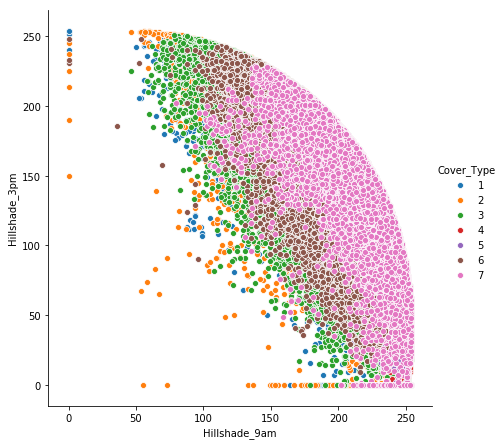

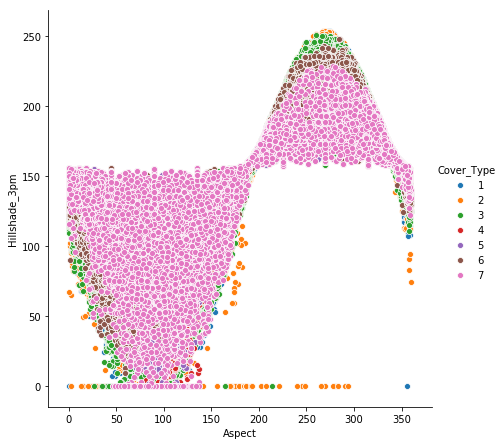

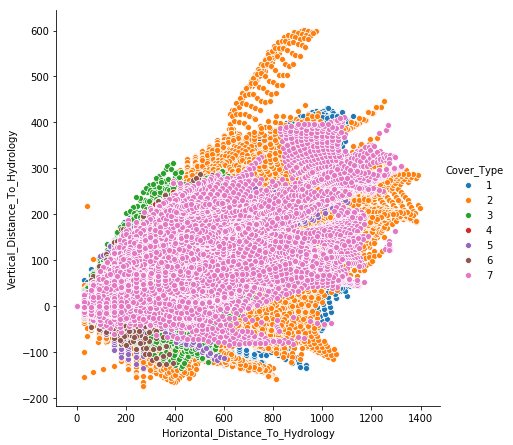

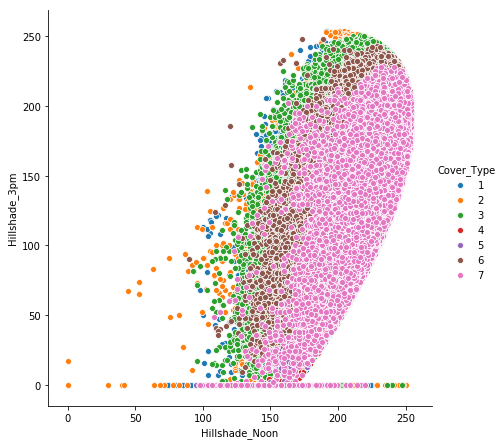

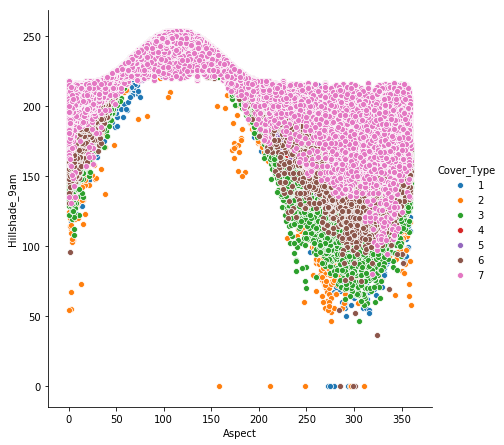

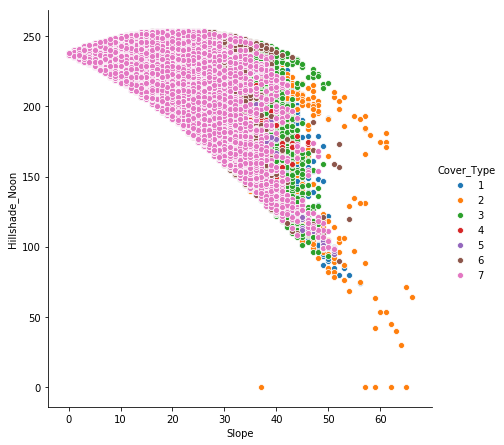

In [ ]:
for v,i,j in s_corr_list:
    sns.pairplot(df, hue="Cover_Type", height=6, x_vars=cols[i],y_vars=cols[j] )
    plt.show()



# DATA VISUALIZATION



*   HEAT MAP
*   BOX PLOT
*   PAIR PLOT



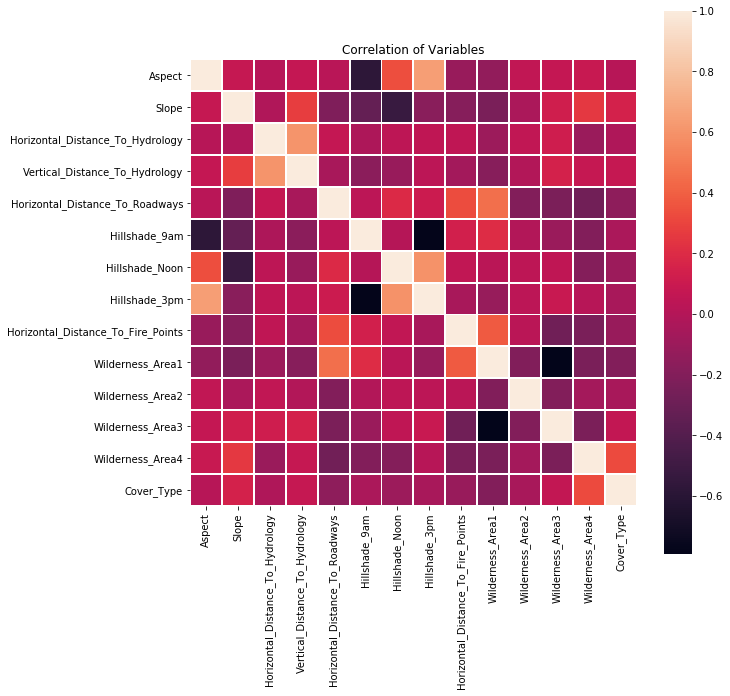

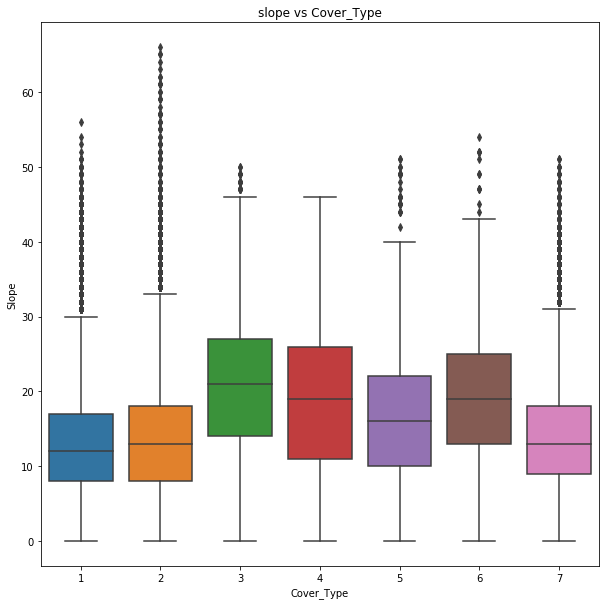

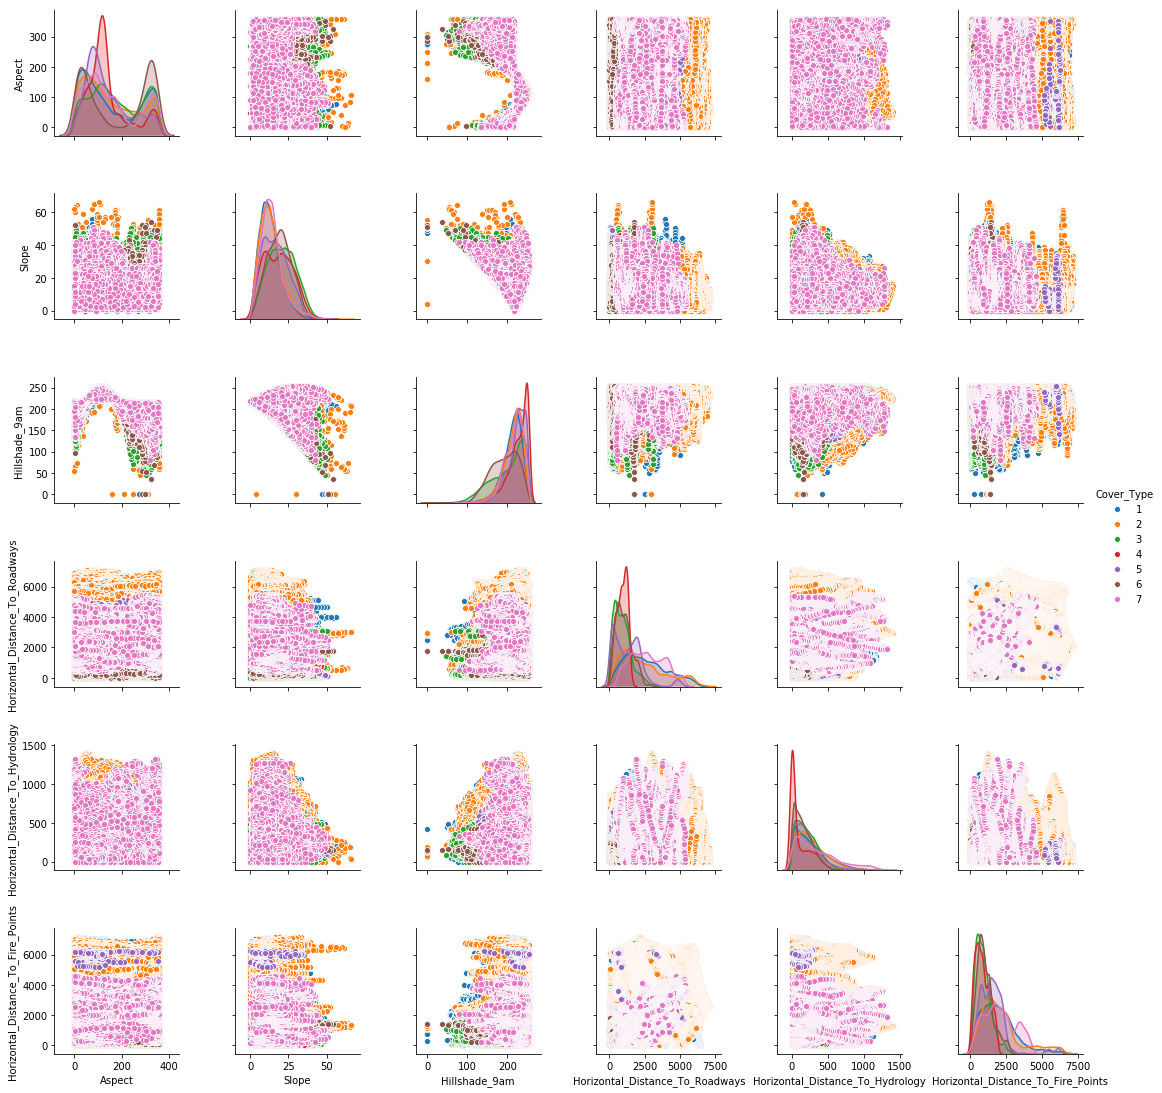

In [ ]:
col_list = df.columns
col_list = [col for col in col_list if not col[0:4]=='Soil']
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[col_list].corr(),square=True,linewidths=1)
plt.title('Correlation of Variables')

plt.figure(figsize=(10,10))
sns.boxplot(y='Slope',x='Cover_Type', data= df )
plt.title('slope vs Cover_Type')


sns.pairplot( df, hue='Cover_Type',vars=['Aspect','Slope','Hillshade_9am','Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Fire_Points'],diag_kind="kde")
plt.show()

**LM PLOT**

*  Horizontal_Distance_To_Hydrology & Vertical_Distance_To_Hydrology with Soil_Type2
*  Horizontal_Distance_To_Hydrology & Vertical_Distance_To_Hydrologywith Wilderness_Area1



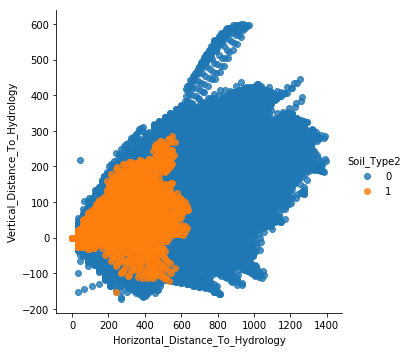

In [ ]:

sns.lmplot(x='Horizontal_Distance_To_Hydrology', y='Vertical_Distance_To_Hydrology', data=df, hue='Soil_Type2',fit_reg=False)

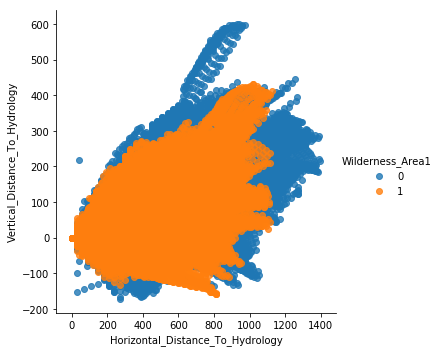

In [ ]:
sns.lmplot(x='Horizontal_Distance_To_Hydrology', y='Vertical_Distance_To_Hydrology', data=df, hue='Wilderness_Area1',fit_reg=False)

* **Violin Plot** - a combination of box and density plots

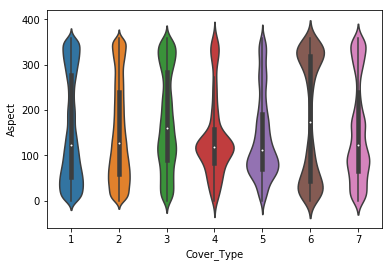

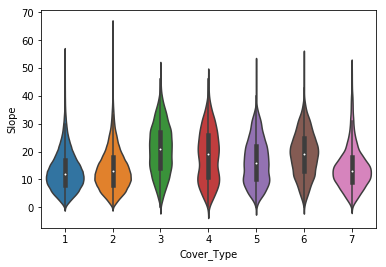

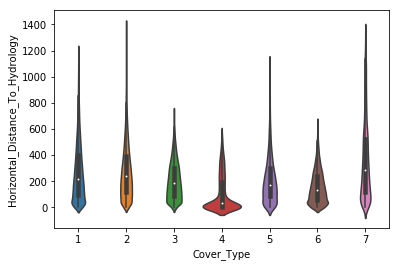

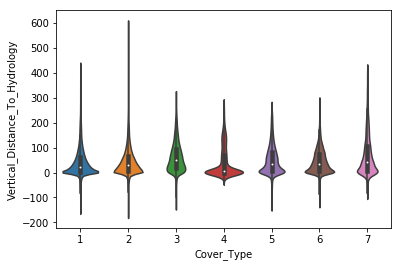

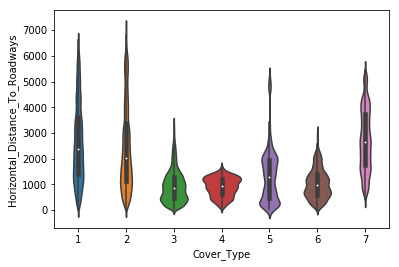

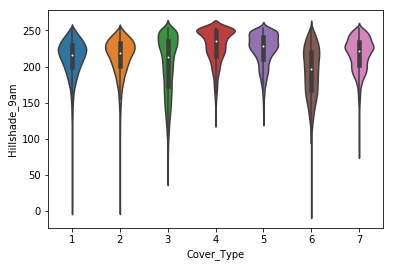

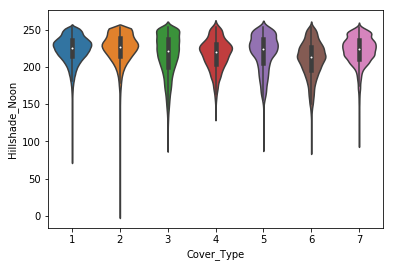

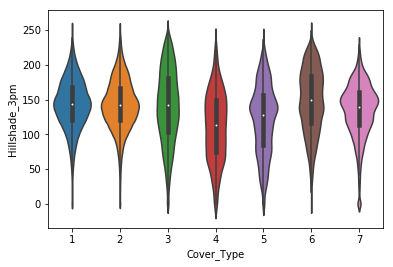

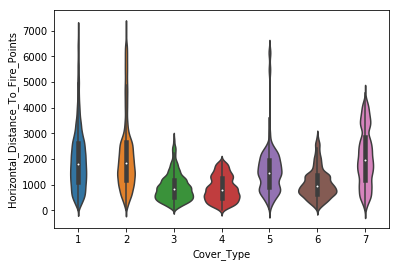

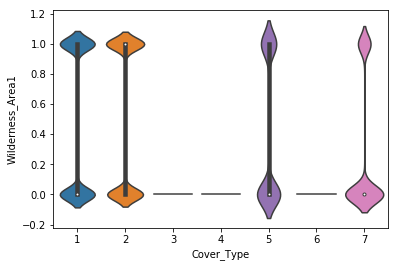

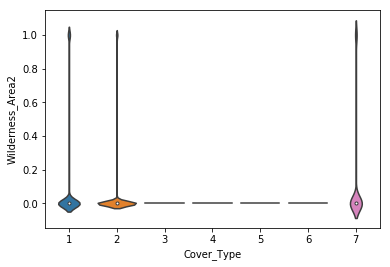

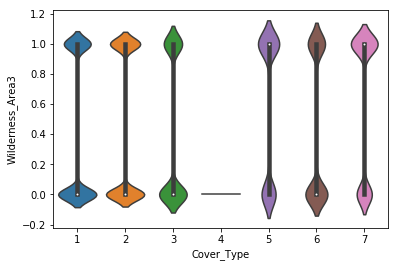

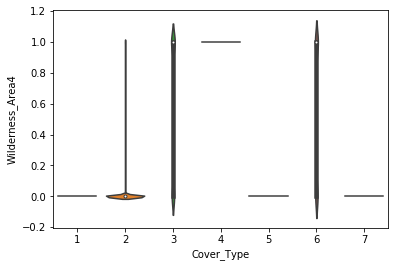

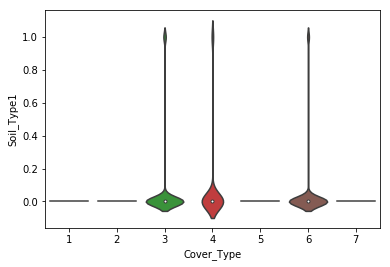

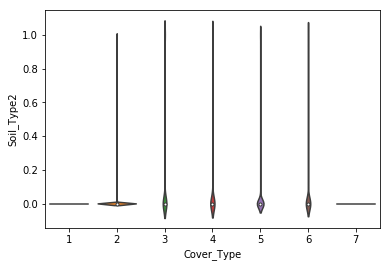

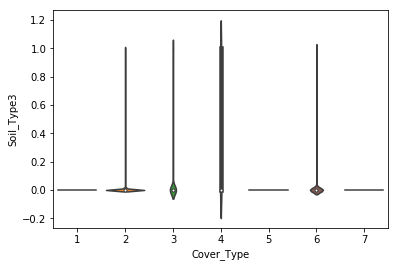

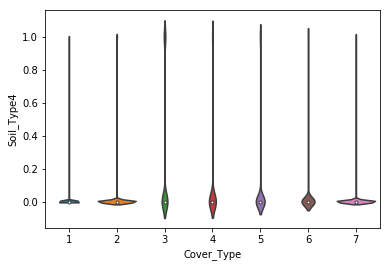

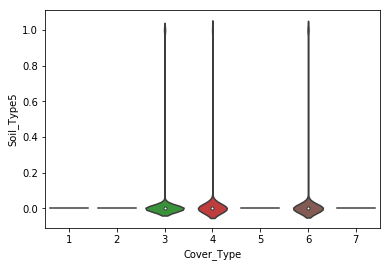

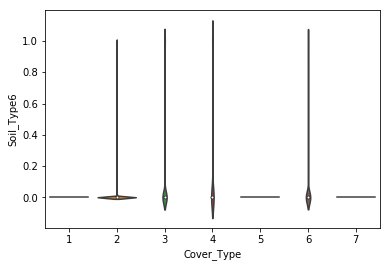

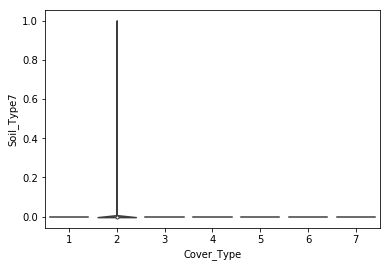

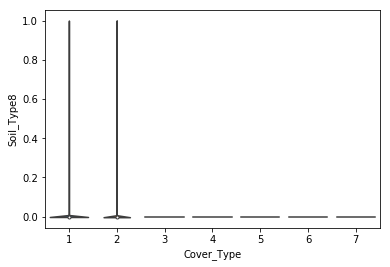

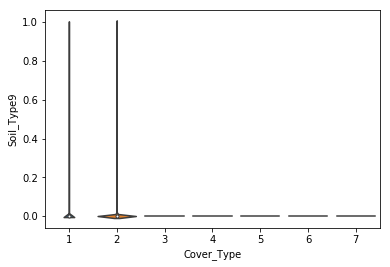

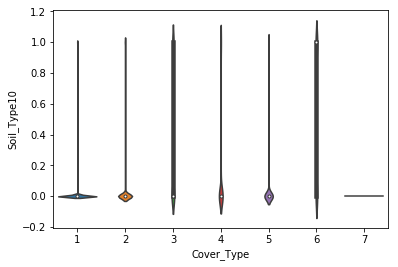

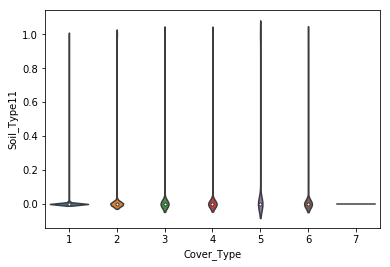

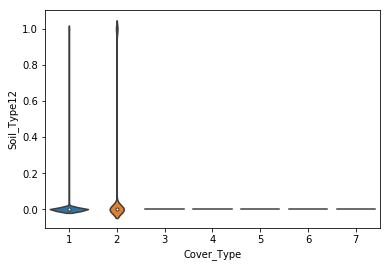

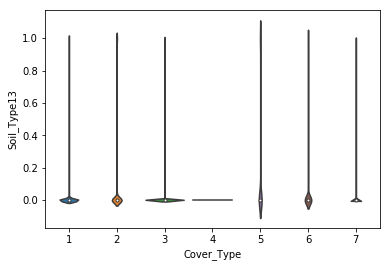

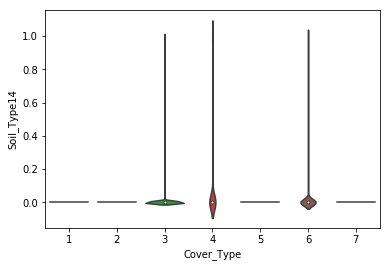

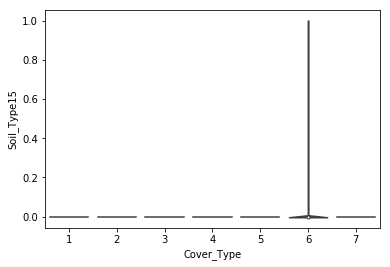

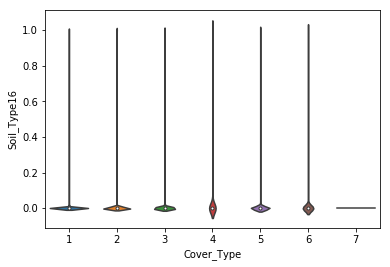

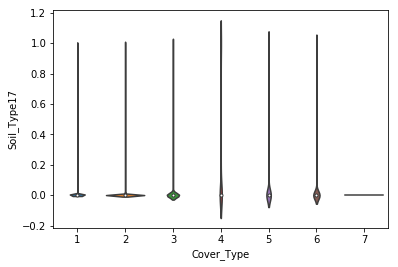

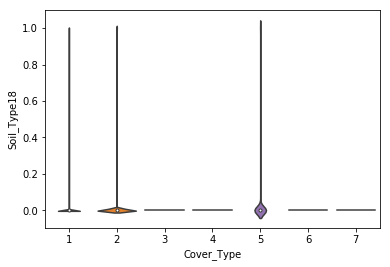

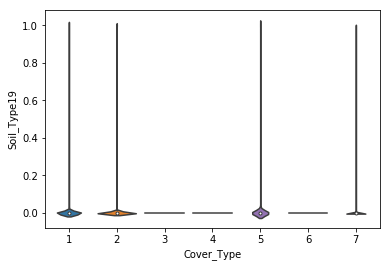

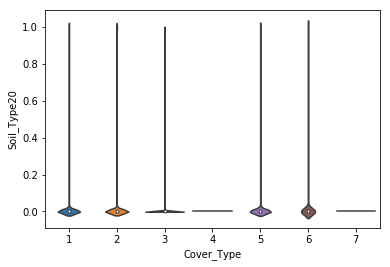

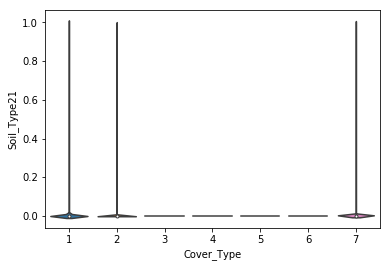

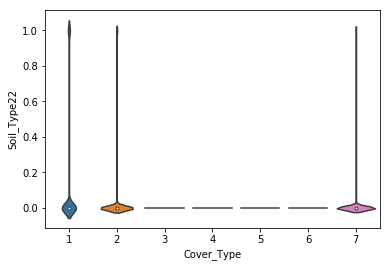

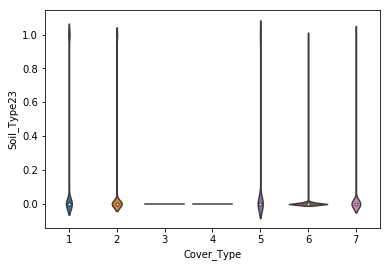

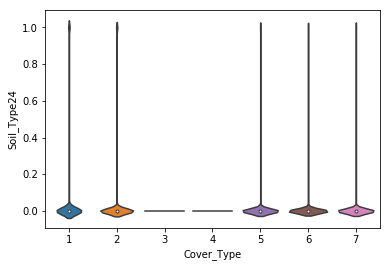

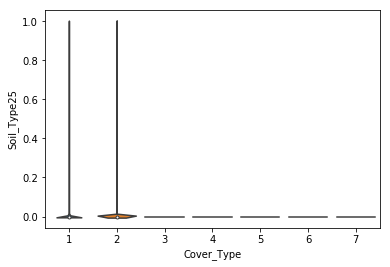

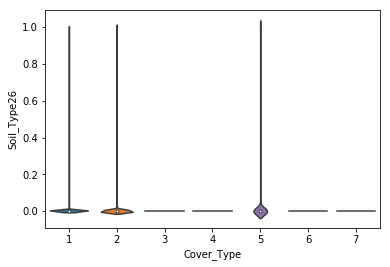

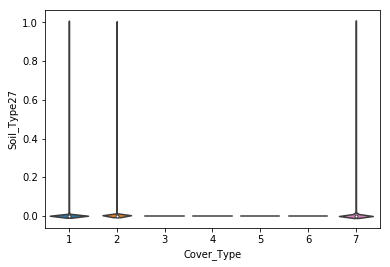

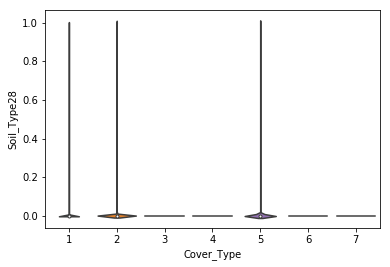

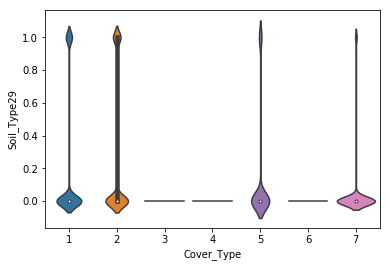

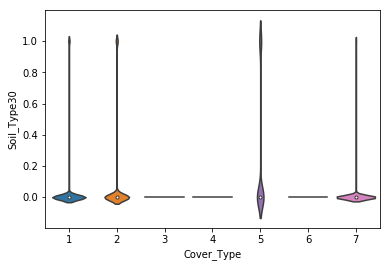

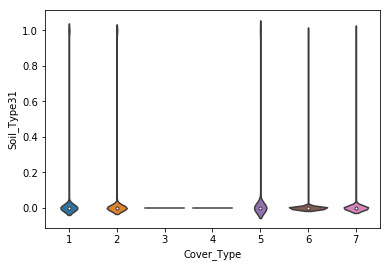

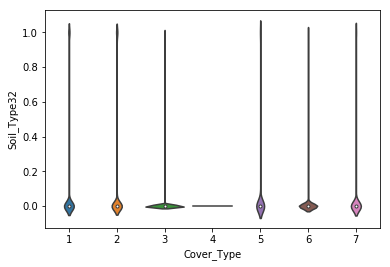

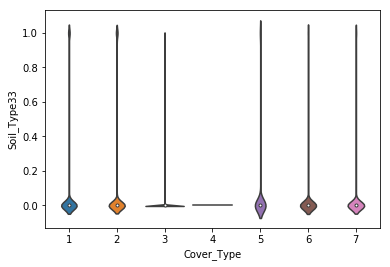

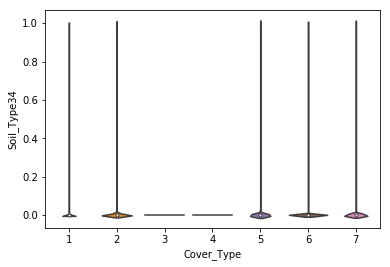

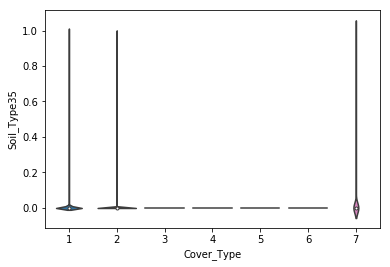

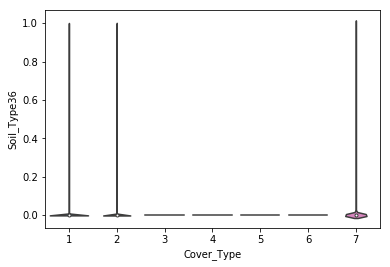

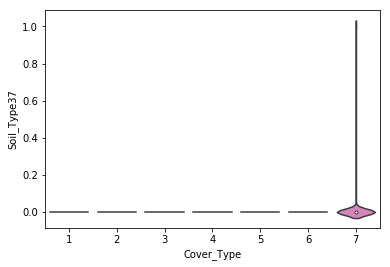

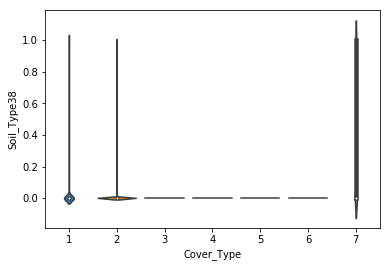

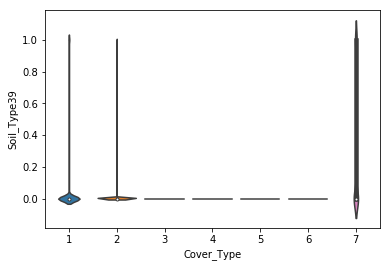

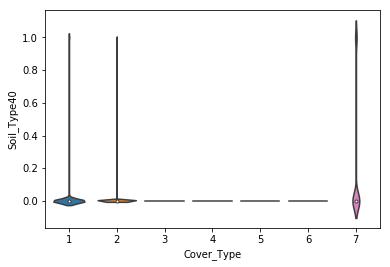

In [ ]:


#names of all the attributes
cols = df.columns

#number of attributes (exclude target)
size = len(cols)-1

#x-axis has target attribute to distinguish between classes
x = cols[size]

#y-axis shows values of an attribute
y = cols[0:size]

#Plot violin for all attributes
for i in range(0,size):
    sns.violinplot(data=df,x=x,y=y[i])
    plt.show()

#Elevation is has a separate distribution for most classes. Highly correlated with the target and hence an important attribute
#Aspect contains a couple of normal distribution for several classes
#Horizontal distance to road and hydrology have similar distribution
#Hillshade 9am and 12pm display left skew
#Hillshade 3pm is normal
#Lots of 0s in vertical distance to hydrology
#Wilderness_Area3 gives no class distinction. As values are not present, others gives some scope to distinguish
#Soil_Type, 1,5,8,9,12,14,18-22, 25-30 and 35-40 offer class distinction as values are not present for many classes